# Queries, Keys and Values

The essence of an **attention mechanism** is
$$\textrm{Attention}(\mathbf{q}, \mathcal{D}) \stackrel{\textrm{def}}{=} \sum_{i=1}^m \alpha(\mathbf{q}, \mathbf{k}_i) \mathbf{v}_i$$
with $\mathcal{D} \stackrel{\textrm{def}}{=} \{(\mathbf{k}_1, \mathbf{v}_1), \ldots (\mathbf{k}_m, \mathbf{v}_m)\}$

The weights $\alpha(\mathbf{q}, \mathbf{k}_i)$ can assume various forms:
* they can be nonnegative
* they can be a probability (i.e. *a convex combination*)
* they can be a one-hot encoding
* they can be all equal, in the form $\frac{1}{m}$

A common practice is to take any function $a(\mathbf{q}, \mathbf{k}_i)$ and to apply *softmax*:
$$\alpha(\mathbf{q}, \mathbf{k}_i) = \frac{\exp(a(\mathbf{q}, \mathbf{k}_i))}{\sum_j \exp(a(\mathbf{q}, \mathbf{k}_j))}$$
The properties of the softmax (of its gradient) make it very desirable for deep learning models.

# Visualization

In [2]:
import torch
from d2l import torch as d2l

Convex weights can be interpreted as a way for the model to select components of relevance.\
It is important to point that it is just an intuition.

In [3]:
#@save
def show_heatmaps(matrices, xlabel, ylabel, titles=None, figsize=(2.5, 2.5), cmap='Reds'):
    """Show heatmaps of matrices."""
    d2l.use_svg_display()
    num_rows, num_cols, _, _ = matrices.shape
    fig, axes = d2l.plt.subplots(
        nrows = num_rows,
        ncols = num_cols,
        figsize = figsize,
        sharex = True,
        sharey=True,
        squeeze=False
    )
    for i, (row_axes, row_matrices) in enumerate(zip(axes, matrices)):
        for j, (ax, matrix) in enumerate(zip(row_axes, row_matrices)):
            pcm = ax.imshow(matrix.detach().numpy(), cmap = cmap)
            if i == num_rows - 1:
                ax.set_xlabel(xlabel)
            if j == 0:
                ax.set_ylabel(ylabel)
            if titles:
                ax.set_title(titles[j])

    fig.colorbar(pcm, ax=axes, shrink=0.6)

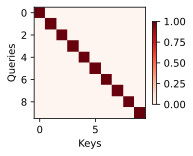

In [4]:
attention_weights = torch.eye(10).reshape(1, 1, 10, 10)
show_heatmaps(
    matrices=attention_weights,
    xlabel='Keys',
    ylabel='Queries'
)

# Attention Pooling by Similarity

Let's try to use attention mechanisms in a regression setting. Check some possible similarity kernels relating queries and key:
$$\begin{split}\begin{aligned}
\alpha(\mathbf{q}, \mathbf{k}) & = \exp\left(-\frac{1}{2} \|\mathbf{q} - \mathbf{k}\|^2 \right) && \textrm{Gaussian;} \\
\alpha(\mathbf{q}, \mathbf{k}) & = 1 \textrm{ if } \|\mathbf{q} - \mathbf{k}\| \leq 1 && \textrm{Boxcar;} \\
\alpha(\mathbf{q}, \mathbf{k}) & = \mathop{\mathrm{max}}\left(0, 1 - \|\mathbf{q} - \mathbf{k}\|\right) && \textrm{Epanechnikov.}
\end{aligned}\end{split}$$

The final equation for regression (or classification) would be something like
$$f(\mathbf{q}) = \sum_i \mathbf{v}_i \frac{\alpha(\mathbf{q}, \mathbf{k}_i)}{\sum_j \alpha(\mathbf{q}, \mathbf{k}_j)}$$

with $\mathbf{v}_i = y_i$, $\mathbf{k}_i = \mathbf{x}_i$, and the queries are (appropriately) regressions on new points.

In [5]:
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

d2l.use_svg_display()

# Kernels and Data

All the kernels are translation and rotation invariant. Let's define some kernels:

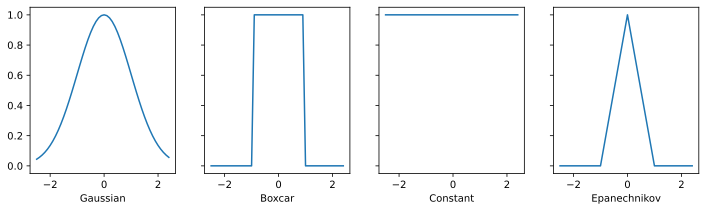

In [6]:
def gaussian(x):
    return torch.exp(-x**2/2)

def boxcar(x):
    return torch.abs(x) < 1.0

def constant(x):
    return 1.0 + 0 * x

def epanechnikov(x):
    return torch.max(1 - torch.abs(x), torch.zeros_like(x))


fig, axes = d2l.plt.subplots(
    nrows=1,
    ncols=4,
    sharey=True,
    figsize=(12, 3)
)

kernels = (gaussian, boxcar, constant, epanechnikov)
names = ('Gaussian', 'Boxcar', 'Constant', 'Epanechnikov')
x = torch.arange(-2.5, 2.5, 0.1)
for kernel, name, ax in zip(kernels, names, axes):
    ax.plot(x.detach().numpy(), kernel(x).detach().numpy())
    ax.set_xlabel(name)

d2l.plt.show()

Let's set up a function (non - deterministic with $\epsilon \sim Norm(0, 1)$):
$$y_i = 2\sin (x_i) + x_i + \epsilon$$

In [7]:
def f(x):
    return 2 * torch.sin(x) + x

n = 40
x_train, _ = torch.sort(torch.rand(n) * 5)
y_train = f(x_train) + torch.randn(n)
x_val = torch.arange(0, 5,  0.1)
y_val = f(x_val)

x_val.reshape((1, -1))

tensor([[0.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000,
         0.9000, 1.0000, 1.1000, 1.2000, 1.3000, 1.4000, 1.5000, 1.6000, 1.7000,
         1.8000, 1.9000, 2.0000, 2.1000, 2.2000, 2.3000, 2.4000, 2.5000, 2.6000,
         2.7000, 2.8000, 2.9000, 3.0000, 3.1000, 3.2000, 3.3000, 3.4000, 3.5000,
         3.6000, 3.7000, 3.8000, 3.9000, 4.0000, 4.1000, 4.2000, 4.3000, 4.4000,
         4.5000, 4.6000, 4.7000, 4.8000, 4.9000]])

# Attention Pooling via Nadaraya - Watson Regression

In [8]:
def nadaraya_watson(x_train, y_train, x_val, y_val, kernel):
    dists = x_train.reshape((-1, 1)) - x_val.reshape((1, -1))
    #print('Vector dists of the function nadaraya_watson')
    #print(dists)
    # Each column/row corresponds to each query/key
    k = kernel(dists).type(torch.float32)
    # Normalization over keys for each query
    attention_w = k / k.sum(0)
    y_hat = y_train @ attention_w
    #print(y_train)
    #print(y_hat)
    return y_hat, attention_w

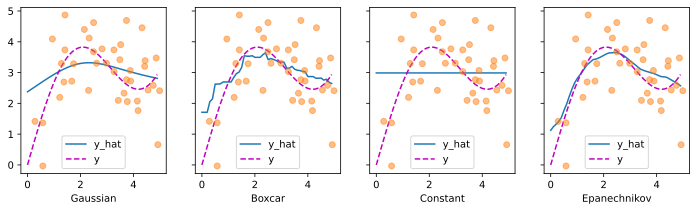

In [9]:
def plot(x_train, y_train, x_val, y_val, kernels, names, attention=False):
    fix, axes = d2l.plt.subplots(
        nrows=1,
        ncols=4,
        sharey=True,
        figsize=(12, 3)
    )
    for kernel, name, ax in zip(kernels, names, axes):
        y_hat, attention_w = nadaraya_watson(x_train, y_train, x_val, y_val, kernel)
        #print('X_train, x_val')
        #print(x_train)
        #print(x_val)
        if attention:
            pcm = ax.imshow(attention_w.detach().numpy(), cmap='Reds')
        else:
            ax.plot(x_val, y_hat)
            ax.plot(x_val, y_val, 'm--')
            ax.plot(x_train, y_train, 'o', alpha=0.5)
        ax.set_xlabel(name)

        if not attention:
            ax.legend(['y_hat', 'y'])
    if attention:
        fig.colorbar(pcm, ax=axes, shrink=0.7)

plot(x_train, y_train, x_val, y_val, kernels, names)

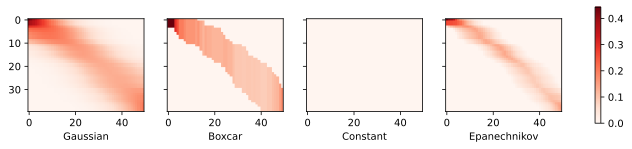

In [10]:
plot(x_train, y_train, x_val, y_val, kernels, names, attention=True)

# Adapting attention pooling

Let's use a different kernel width:
$$\alpha(\mathbf{q}, \mathbf{k}) = \exp\left(-\frac{1}{2 \sigma^2} \|\mathbf{q} - \mathbf{k}\|^2 \right)$$

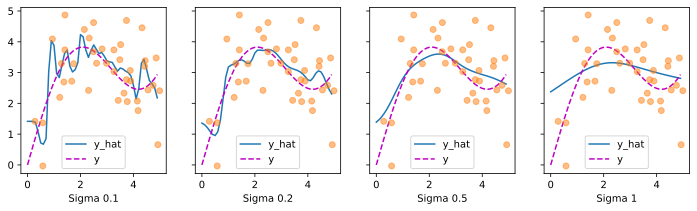

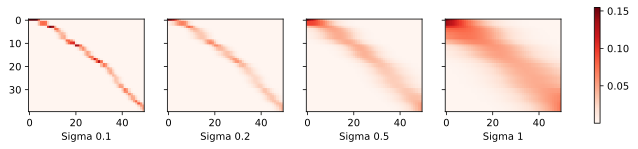

In [11]:
sigmas = (0.1, 0.2, 0.5, 1)
names = ['Sigma ' + str(sigma) for sigma in sigmas]

def gaussian_with_width(sigma):
    return (lambda x: torch.exp(-x**2 / (2*sigma**2)))

kernels = [gaussian_with_width(sigma) for sigma in sigmas]
plot(x_train, y_train, x_val, y_val, kernels, names)
plot(x_train, y_train, x_val, y_val, kernels, names, attention=True)

# Dot Product Attention

In [12]:
import math
import torch
from torch import nn
from d2l import torch as d2l

Consider the Gaussian kernel:
$$a(\mathbf{q}, \mathbf{k}_i) = -\frac{1}{2} \|\mathbf{q} - \mathbf{k}_i\|^2  = \mathbf{q}^\top \mathbf{k}_i -\frac{1}{2} \|\mathbf{k}_i\|^2  -\frac{1}{2} \|\mathbf{q}\|^2$$
Since most of the times
* $||\mathbf{q}||$ is bounded
* $||\mathbf{k_i}||$ is bounded

In order to have the first term bounded, we just need to
$$\alpha(\mathbf{q}, \mathbf{k}_i) = \mathrm{softmax}(a(\mathbf{q}, \mathbf{k}_i)) = \frac{\exp(\mathbf{q}^\top \mathbf{k}_i / \sqrt{d})}{\sum_{j=1} \exp(\mathbf{q}^\top \mathbf{k}_j / \sqrt{d})}.$$

In [13]:
def masked_softmax(X, valid_lens): #@save
    """Perform softmax operation by masking elements on the last axis."""
    # X: 3D tensor, valid_lens: 1D or 2D tensor
    def _sequence_mask(X, valid_len, value=0):
        maxlen = X.size(1)
        mask = torch.arange((maxlen), dtype=torch.float32, device=X.device)[None, :] < valid_len[:, None]

        X[~mask] = value
        return X
    
    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        # On the last axis, replace masked elements with a very large negative
        # value, whose exponentiation outputs 0

        X = _sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=-1)

In [14]:
#Example
masked_softmax(torch.rand(2, 2, 4), torch.tensor([2, 3]))

tensor([[[0.4485, 0.5515, 0.0000, 0.0000],
         [0.3475, 0.6525, 0.0000, 0.0000]],

        [[0.4060, 0.2570, 0.3370, 0.0000],
         [0.4007, 0.2771, 0.3222, 0.0000]]])

In [15]:
# Another example
masked_softmax(torch.rand(2, 2, 4), torch.tensor([[1, 3], [2, 4]]))

tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.3228, 0.3852, 0.2920, 0.0000]],

        [[0.3802, 0.6198, 0.0000, 0.0000],
         [0.3140, 0.2507, 0.2986, 0.1367]]])

### Batch matrix multiplication
$$\begin{split}\mathbf{Q} = [\mathbf{Q}_1, \mathbf{Q}_2, \ldots, \mathbf{Q}_n]  \in \mathbb{R}^{n \times a \times b}, \\
    \mathbf{K} = [\mathbf{K}_1, \mathbf{K}_2, \ldots, \mathbf{K}_n]  \in \mathbb{R}^{n \times b \times c}.\end{split}$$
$$\textrm{BMM}(\mathbf{Q}, \mathbf{K}) = [\mathbf{Q}_1 \mathbf{K}_1, \mathbf{Q}_2 \mathbf{K}_2, \ldots, \mathbf{Q}_n \mathbf{K}_n] \in \mathbb{R}^{n \times a \times c}.$$

In [16]:
Q = torch.ones((2, 3, 4))
K = torch.ones((2, 4, 6))
d2l.check_shape(torch.bmm(Q, K), (2, 3, 6))

The scaled (referred to minibatches) **dot product attention** is defined as
$$\mathrm{softmax}\left(\frac{\mathbf Q \mathbf K^\top }{\sqrt{d}}\right) \mathbf V \in \mathbb{R}^{n\times v}$$
This uses batch matrix multiplication. Note the dropout in the implementation

In [17]:
class DotProductAttention(nn.Module):   #@save
    """Scaled dot product attention."""
    def __init__(self, dropout):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
    # Shape of queries: (batch_size, no. of queries, d)
    # Shape of keys: (batch_size, no. of key-value pairs, d)
    # Shape of values: (batch_size, no. of key-value pairs, value dimension)
    # Shape of valid_lens: (batch_size,) or (batch_size, no. of queries)

    def forward(self, queries, keys, values, valid_lens=None):
        d = queries.shape[-1]
        # Swap the last two dimensions of the keys with keys.transpose(1, 2)
        scores = torch.bmm(queries, keys.transpose(1, 2)) / math.sqrt(d)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

Let's run an example:

In [18]:
queries = torch.normal(0, 1, (2, 1, 2))
keys = torch.normal(0, 1, (2, 10, 2))
values = torch.normal(0, 1, (2, 10, 4))
valid_lens = torch.tensor([2, 6])

attention = DotProductAttention(dropout=0.5)
attention.eval()
d2l.check_shape(attention(queries, keys, values, valid_lens), (2, 1, 4))

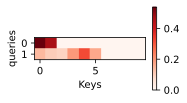

In [19]:
d2l.show_heatmaps(
    matrices=attention.attention_weights.reshape((1, 1, 2, 10)),
    xlabel='Keys',
    ylabel='queries'
)

In [20]:
class AdditiveAttention(nn.Module):     #@save
    """Additive attention"""
    def __init__(self, num_hiddens, dropout, **kwargs):
        super(AdditiveAttention, self).__init__(**kwargs)
        self.W_k = nn.LazyLinear(num_hiddens, bias=False)
        self.W_q = nn.LazyLinear(num_hiddens, bias=False)
        self.w_v = nn.LazyLinear(1, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, valid_lens):
        queries, keys = self.W_q(queries), self.W_k(keys)
         # After dimension expansion, shape of queries: (batch_size, no. of
        # queries, 1, num_hiddens) and shape of keys: (batch_size, 1, no. of
        # key-value pairs, num_hiddens). Sum them up with broadcasting
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        features = torch.tanh(features)
        # There is only one output of self.w_v, so we remove the last
        # one-dimensional entry from the shape. Shape of scores:
        # (batch_size, no. of queries, no. of key-value pairs)
        scores = self.w_v(features).squeeze(-1)
        self.attention_weights = masked_softmax(scores, valid_lens)
        # Shape of values: (batch_size, no. of key-value pairs, value dimension)
        return torch.bmm(self.dropout(self.attention_weights), values)

In [21]:
queries = torch.normal(0, 1, (2, 1, 20))
attention = AdditiveAttention(num_hiddens=8, dropout=0.1)
attention.eval()
d2l.check_shape(attention(queries, keys, values, valid_lens), (2, 1, 4))

/home/pachy/.cache/pypoetry/virtualenvs/dive_into_deep_learning-88_68WVw-py3.10/lib/python3.10/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


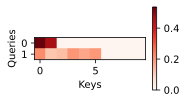

In [22]:
d2l.show_heatmaps(attention.attention_weights.reshape(1, 1, 2, 10), xlabel='Keys', ylabel='Queries')

# The Bahdanau Attention Mechanism

In [1]:
import torch
from torch import nn
from d2l import torch as d2l